In [3]:
%matplotlib notebook

import os
import sys
import cv2
import matplotlib.pyplot as plt
import numpy as np
from darkflow.net.build import TFNet
import track.sort.sort as srt

ImportError: /usr/lib/x86_64-linux-gnu/libgtk-3.so.0: undefined symbol: pango_attr_foreground_alpha_new

In [1]:
# print(os.getcwd())
# os.chdir('..')
# %run store_results.py

ImportError: /usr/lib/x86_64-linux-gnu/libpangoft2-1.0.so.0: undefined symbol: hb_buffer_set_cluster_level

In [3]:
# directory with images from video
working_directory = '/home/analyticsuser/data/Husband Surprises Wife by Filling House With Puppies!'
#working_directory = '/home/analyticsuser/data/Nest Cam - Owner catches burglars in act on her phone'
#working_directory = '/data01/OC_RESINET/process/ResiIndoor03-YT/Indoor-family2'

# only images
files_in_directory = sorted([os.path.join(working_directory, file_name)
                      for file_name in os.listdir(working_directory)
                      if os.path.splitext(file_name)[1].lower() in ('.jpg', '.jpeg')])

# colors for different bboxes for visualization
colors = [(255,0,0), (0,255,0),(0,0,255),(255,255,0),(0,255,255),(255,0,255),(192,192,192),(128,128,128),
          (128,0,0),(128,128,0),(0,128,0),(128,0,128),(0,128,128),(0,0,128),(0,0,0)]

# configuration for YOLO
options = {'model': '/home/analyticsuser/darkflow/cfg/yolo.2.0.cfg', 
           'load': '/home/analyticsuser/darkflow/cfg/yolo.2.0.weights', 'threshold': 0.1}
# options = {'model': '/home/analyticsuser/darkflow/cfg/tiny-yolo.cfg', 
#            'load': '/home/analyticsuser/darkflow/cfg/tiny-yolo.weights', 'threshold': 0.1}

tfnet = TFNet(options)

# initialize SORT tracker:
# mot_tracker = srt.Sort(10,1,5,0.8,0.94,0.8,2.0)
# - 10 consecutive frames with no detection to terminate an existing track
# - 1 consecutive frame (i.e. after an initial frame) to activate the new track (before that will not produce any output)
# - 5 frames to extrapolate an active track (i.e. show predicted output eventhough no detection present for this track)
# - 0.8 unassigned detection over track bbox overlap (intersection over union) threshold to eliminate the detection
# - 0.94 unassigned detection over another stronger unassigned detection overlap (intersection over self bbox area) threshold to eliminate the detection
# - 0.8 unassigned detection over another stronger unassigned detection overlap (intersection over larger bbox area) threshold to eliminate the detection
# - 2.0 defines "stronger" detection disregarding the size -- if the score of the unassigned detection overlapping 
#       another unassigned detection is 2.0-times higher than the score of the other detection, it is stronger, otherwise 
#       larger size decides
mot_tracker = srt.Sort(10,0,10,0.55,0.90,0.6,2.0)

Parsing ./cfg/yolo.2.0.cfg
Parsing /home/analyticsuser/darkflow/cfg/yolo.2.0.cfg
Loading /home/analyticsuser/darkflow/cfg/yolo.2.0.weights ...
Successfully identified 269862452 bytes
Finished in 0.048337459564208984s


In [ ]:
def visualize_rectangle(imgcv,detection,colors,idx):
    # detected rectangle
    cv2.rectangle(imgcv, (detection['topleft']['x'], detection['topleft']['y']), 
                  (detection['bottomright']['x'], detection['bottomright']['y']), 
                  colors[idx % len(colors)], 10)
    # gray background bellow text
    cv2.rectangle(imgcv, (detection['topleft']['x'], detection['topleft']['y'] - 20), 
                  (detection['bottomright']['x'], detection['topleft']['y']), (125, 125, 125), -1)
    # text class:confidence
    cv2.putText(imgcv, detection['label'] + ' : %.2f' % detection['confidence'], 
                (detection['topleft']['x'] + 5, detection['topleft']['y'] - 7), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)

    
##########################################################
# split detection on stacked image into upper/lower view,     
# reduce the size of upper bbox when overlaid to bottom view
# set new coordinates to lower view (remove height/2)
def split_detection(imgcv, result):  
    detection1 = list([])
    detection2 = list([])
    height,width,cspace = imgcv.shape
    
    #result_filter = list(filter(lambda x: x['label'] == 'person' or x['label'] == 'dog' or x['label'] == 'cat',result))
    result_filter = list(filter(lambda x: x['label'] == 'person',result))
    detection1 = list(filter(lambda x: x['topleft']['y'] < height/2,result_filter))
    detection2 = list(filter(lambda x: x['topleft']['y'] >= height/2,result_filter))
    # for detection1 we have to limit the height
    for d in detection1:
        #print([height/2, d['bottomright']['y']])
        d['bottomright']['y'] = int(np.min([height/2, d['bottomright']['y']]))
    
    # for detection2 we need to substract the height/2
    #detection2 = list(map(lambda x: float(x['topleft']['y']) - height/2, detection2))
    for d in detection2:
        #print(d)
        d['topleft']['y'] -= int(height/2)
        d['bottomright']['y'] -= int(height/2)

    return detection1, detection2

<IPython.core.display.Javascript object>


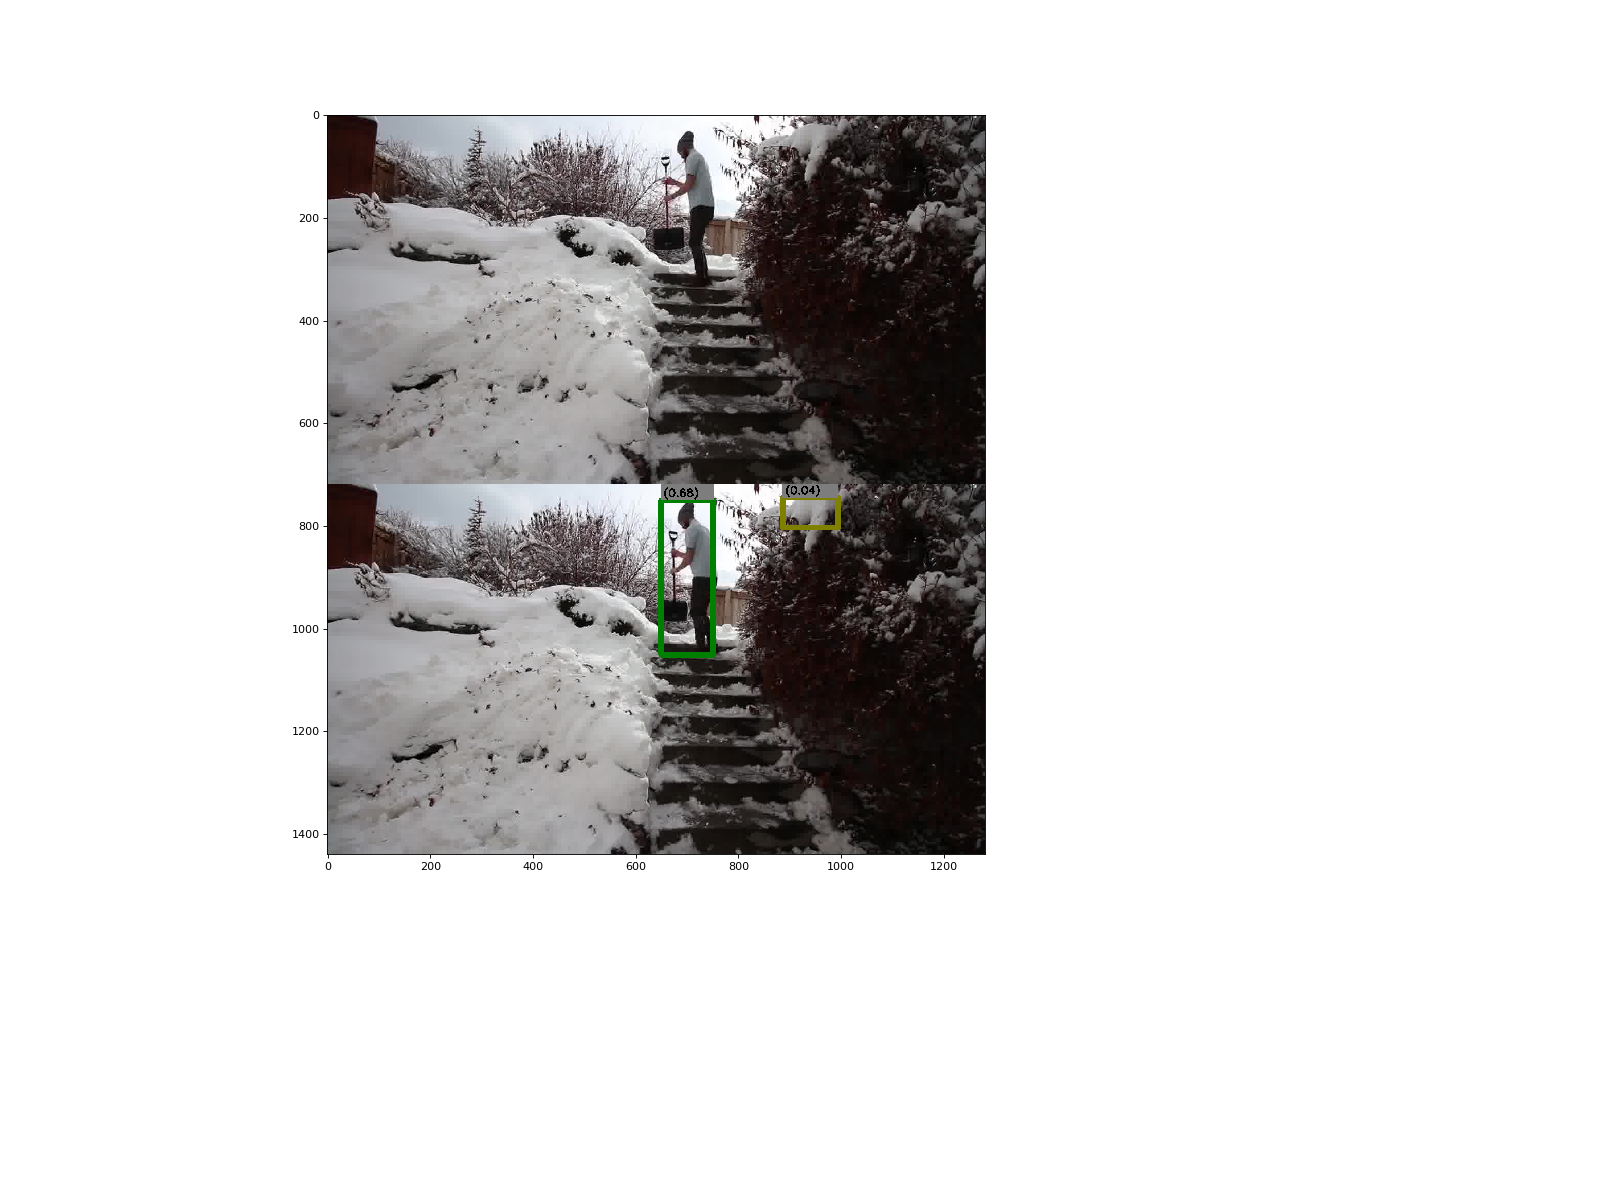

<class 'list'>
['detection1 = ', []]
['detection2 = ', []]
stacked again
set_data
draw
done
<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.23126775, 'topleft': {'x': 1211, 'y': 0}, 'bottomright': {'x': 1279, 'y': 184}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.30000877, 'topleft': {'x': 1155, 'y': 0}, 'bottomright': {'x': 1270, 'y': 646}}]]
stacked again
set_data
draw
done
<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.11692474, 'topleft': {'x': 994, 'y': 73}, 'bottomright': {'x': 1256, 'y': 720}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.42658043, 'topleft': {'x': 1041, 'y': 12}, 'bottomright': {'x': 1258, 'y': 679}}, {'label': 'person', 'confidence': 0.26182258, 'topleft': {'x': 1169, 'y': 138}, 'bottomright': {'x': 1276, 'y': 718}}]]
stacked again
set_data
draw
done


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.71533775, 'topleft': {'x': 782, 'y': 246}, 'bottomright': {'x': 1279, 'y': 720}}, {'label': 'person', 'confidence': 0.13046947, 'topleft': {'x': 777, 'y': 360}, 'bottomright': {'x': 1276, 'y': 720}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.59177321, 'topleft': {'x': 790, 'y': 282}, 'bottomright': {'x': 1273, 'y': 719}}]]
stacked again
set_data
draw
done
<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.43099207, 'topleft': {'x': 700, 'y': 248}, 'bottomright': {'x': 1225, 'y': 720}}, {'label': 'person', 'confidence': 0.10649383, 'topleft': {'x': 645, 'y': 349}, 'bottomright': {'x': 1238, 'y': 720}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.73786622, 'topleft': {'x': 635, 'y': 311}, 'bottomright': {'x': 1267, 'y': 719}}]]
stacked again
set_data
draw
done
<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.54821599, 'topleft': {'x': 698, 'y': 262}, 'bo

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.49334562, 'topleft': {'x': 659, 'y': 386}, 'bottomright': {'x': 1226, 'y': 720}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.69368494, 'topleft': {'x': 629, 'y': 330}, 'bottomright': {'x': 1248, 'y': 719}}]]
stacked again
set_data
draw
done
<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.47432482, 'topleft': {'x': 628, 'y': 298}, 'bottomright': {'x': 1239, 'y': 720}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.62105709, 'topleft': {'x': 627, 'y': 320}, 'bottomright': {'x': 1237, 'y': 719}}]]
stacked again
set_data
draw
done
<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.71100742, 'topleft': {'x': 625, 'y': 293}, 'bottomright': {'x': 1246, 'y': 720}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.63468808, 'topleft': {'x': 613, 'y': 294}, 'bottomright': {'x': 1232, 'y': 719}}]]
stacked again
set_data
draw
done
<class 'list'>
['detection1 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.79960209, 'topleft': {'x': 574, 'y': 88}, 'bottomright': {'x': 1243, 'y': 720}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.11371621, 'topleft': {'x': 88, 'y': 190}, 'bottomright': {'x': 357, 'y': 326}}, {'label': 'person', 'confidence': 0.74971199, 'topleft': {'x': 585, 'y': 78}, 'bottomright': {'x': 1261, 'y': 719}}]]
stacked again
set_data
draw
done
<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.71821672, 'topleft': {'x': 611, 'y': 63}, 'bottomright': {'x': 1243, 'y': 720}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.10574463, 'topleft': {'x': 89, 'y': 185}, 'bottomright': {'x': 353, 'y': 325}}, {'label': 'person', 'confidence': 0.78931767, 'topleft': {'x': 578, 'y': 97}, 'bottomright': {'x': 1279, 'y': 719}}]]
stacked again
set_data
draw
done
<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.84417522, 'topleft': {'x': 645, 'y': 71}, 'bottomright

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.82128555, 'topleft': {'x': 707, 'y': 120}, 'bottomright': {'x': 1234, 'y': 716}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.84219271, 'topleft': {'x': 727, 'y': 110}, 'bottomright': {'x': 1175, 'y': 699}}, {'label': 'dog', 'confidence': 0.1062434, 'topleft': {'x': 0, 'y': 229}, 'bottomright': {'x': 741, 'y': 646}}, {'label': 'dog', 'confidence': 0.11022101, 'topleft': {'x': 532, 'y': 425}, 'bottomright': {'x': 778, 'y': 703}}]]
stacked again
set_data
draw
done
<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.80151254, 'topleft': {'x': 712, 'y': 120}, 'bottomright': {'x': 1231, 'y': 716}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.82174337, 'topleft': {'x': 699, 'y': 105}, 'bottomright': {'x': 1217, 'y': 701}}, {'label': 'dog', 'confidence': 0.14702812, 'topleft': {'x': 0, 'y': 230}, 'bottomright': {'x': 744, 'y': 651}}, {'label': 'dog', 'confidence': 0.18747555, 'tople

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.85757881, 'topleft': {'x': 682, 'y': 133}, 'bottomright': {'x': 1016, 'y': 707}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.12985533, 'topleft': {'x': 90, 'y': 192}, 'bottomright': {'x': 354, 'y': 330}}, {'label': 'person', 'confidence': 0.86258459, 'topleft': {'x': 668, 'y': 100}, 'bottomright': {'x': 1009, 'y': 702}}, {'label': 'dog', 'confidence': 0.11903175, 'topleft': {'x': 0, 'y': 227}, 'bottomright': {'x': 726, 'y': 656}}]]
stacked again
set_data
draw
done
<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.84056056, 'topleft': {'x': 677, 'y': 133}, 'bottomright': {'x': 1007, 'y': 707}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.12501661, 'topleft': {'x': 91, 'y': 191}, 'bottomright': {'x': 353, 'y': 330}}, {'label': 'person', 'confidence': 0.8513335, 'topleft': {'x': 668, 'y': 99}, 'bottomright': {'x': 1009, 'y': 708}}, {'label': 'dog', 'confidence': 0.14625737, '

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.8391521, 'topleft': {'x': 656, 'y': 98}, 'bottomright': {'x': 1064, 'y': 720}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.1073575, 'topleft': {'x': 91, 'y': 191}, 'bottomright': {'x': 351, 'y': 330}}, {'label': 'person', 'confidence': 0.79430008, 'topleft': {'x': 649, 'y': 87}, 'bottomright': {'x': 1089, 'y': 709}}, {'label': 'dog', 'confidence': 0.22268479, 'topleft': {'x': 0, 'y': 225}, 'bottomright': {'x': 729, 'y': 655}}, {'label': 'dog', 'confidence': 0.14451554, 'topleft': {'x': 530, 'y': 437}, 'bottomright': {'x': 780, 'y': 677}}]]
stacked again
set_data
draw
done
<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.80034143, 'topleft': {'x': 644, 'y': 95}, 'bottomright': {'x': 1086, 'y': 720}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.11437897, 'topleft': {'x': 91, 'y': 189}, 'bottomright': {'x': 353, 'y': 331}}, {'label': 'person', 'confidence': 0.75516224, 'topl

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.85698074, 'topleft': {'x': 676, 'y': 80}, 'bottomright': {'x': 1130, 'y': 720}}, {'label': 'person', 'confidence': 0.11713095, 'topleft': {'x': 646, 'y': 530}, 'bottomright': {'x': 853, 'y': 720}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.11133362, 'topleft': {'x': 89, 'y': 190}, 'bottomright': {'x': 356, 'y': 331}}, {'label': 'person', 'confidence': 0.7959094, 'topleft': {'x': 677, 'y': 81}, 'bottomright': {'x': 1137, 'y': 719}}, {'label': 'dog', 'confidence': 0.20112638, 'topleft': {'x': 0, 'y': 220}, 'bottomright': {'x': 732, 'y': 659}}]]
stacked again
set_data
draw
done
<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.84623671, 'topleft': {'x': 673, 'y': 71}, 'bottomright': {'x': 1140, 'y': 720}}, {'label': 'person', 'confidence': 0.12659852, 'topleft': {'x': 640, 'y': 535}, 'bottomright': {'x': 854, 'y': 718}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.8044017, '

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.76953018, 'topleft': {'x': 615, 'y': 63}, 'bottomright': {'x': 1117, 'y': 720}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.75988501, 'topleft': {'x': 677, 'y': 88}, 'bottomright': {'x': 1129, 'y': 719}}, {'label': 'dog', 'confidence': 0.21169223, 'topleft': {'x': 0, 'y': 203}, 'bottomright': {'x': 736, 'y': 668}}]]
stacked again
set_data
draw
done
<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.74819553, 'topleft': {'x': 670, 'y': 78}, 'bottomright': {'x': 1137, 'y': 720}}, {'label': 'dog', 'confidence': 0.11221936, 'topleft': {'x': 0, 'y': 257}, 'bottomright': {'x': 755, 'y': 710}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.77745849, 'topleft': {'x': 605, 'y': 87}, 'bottomright': {'x': 1133, 'y': 719}}, {'label': 'dog', 'confidence': 0.25771514, 'topleft': {'x': 0, 'y': 205}, 'bottomright': {'x': 741, 'y': 669}}]]
stacked again
set_data
draw
done
<class 'list'>
['det

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.82933921, 'topleft': {'x': 558, 'y': 193}, 'bottomright': {'x': 988, 'y': 720}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.81259161, 'topleft': {'x': 563, 'y': 223}, 'bottomright': {'x': 961, 'y': 719}}]]
stacked again
set_data
draw
done
<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.85968053, 'topleft': {'x': 545, 'y': 209}, 'bottomright': {'x': 985, 'y': 720}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.85432667, 'topleft': {'x': 547, 'y': 208}, 'bottomright': {'x': 957, 'y': 719}}]]
stacked again
set_data
draw
done
<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.84709799, 'topleft': {'x': 534, 'y': 227}, 'bottomright': {'x': 977, 'y': 720}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.78646111, 'topleft': {'x': 553, 'y': 234}, 'bottomright': {'x': 967, 'y': 719}}]]
stacked again
set_data
draw
done
<class 'list'>
['detection1 = ', [

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.15561152, 'topleft': {'x': 601, 'y': 365}, 'bottomright': {'x': 882, 'y': 676}}, {'label': 'person', 'confidence': 0.16551411, 'topleft': {'x': 530, 'y': 275}, 'bottomright': {'x': 987, 'y': 720}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.16054694, 'topleft': {'x': 539, 'y': 250}, 'bottomright': {'x': 978, 'y': 696}}]]
stacked again
set_data
draw
done
<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.4304179, 'topleft': {'x': 521, 'y': 266}, 'bottomright': {'x': 980, 'y': 720}}, {'label': 'dog', 'confidence': 0.10590719, 'topleft': {'x': 683, 'y': 504}, 'bottomright': {'x': 993, 'y': 720}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.36746836, 'topleft': {'x': 604, 'y': 315}, 'bottomright': {'x': 897, 'y': 633}}]]
stacked again
set_data
draw
done
<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.7234835, 'topleft': {'x': 641, 'y': 313}, 'bottomright':

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.69081157, 'topleft': {'x': 682, 'y': 214}, 'bottomright': {'x': 910, 'y': 620}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.74790823, 'topleft': {'x': 652, 'y': 215}, 'bottomright': {'x': 891, 'y': 667}}]]
stacked again
set_data
draw
done
<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.64366037, 'topleft': {'x': 657, 'y': 209}, 'bottomright': {'x': 884, 'y': 626}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.10756631, 'topleft': {'x': 671, 'y': 247}, 'bottomright': {'x': 861, 'y': 452}}, {'label': 'person', 'confidence': 0.73907667, 'topleft': {'x': 656, 'y': 241}, 'bottomright': {'x': 888, 'y': 667}}]]
stacked again
set_data
draw
done
<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.77120739, 'topleft': {'x': 654, 'y': 208}, 'bottomright': {'x': 888, 'y': 622}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.26156554, 'topleft': {'x': 679, 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.65322143, 'topleft': {'x': 666, 'y': 222}, 'bottomright': {'x': 861, 'y': 543}}, {'label': 'person', 'confidence': 0.13586695, 'topleft': {'x': 686, 'y': 353}, 'bottomright': {'x': 917, 'y': 632}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.55809838, 'topleft': {'x': 674, 'y': 227}, 'bottomright': {'x': 863, 'y': 645}}]]
stacked again
set_data
draw
done


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.64935887, 'topleft': {'x': 673, 'y': 220}, 'bottomright': {'x': 865, 'y': 601}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.2109769, 'topleft': {'x': 688, 'y': 250}, 'bottomright': {'x': 840, 'y': 429}}, {'label': 'person', 'confidence': 0.42437807, 'topleft': {'x': 676, 'y': 253}, 'bottomright': {'x': 863, 'y': 640}}]]
stacked again
set_data
draw
done


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.55052888, 'topleft': {'x': 671, 'y': 302}, 'bottomright': {'x': 877, 'y': 647}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.6832245, 'topleft': {'x': 667, 'y': 254}, 'bottomright': {'x': 862, 'y': 626}}]]
stacked again
set_data
draw
done


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.77356941, 'topleft': {'x': 684, 'y': 207}, 'bottomright': {'x': 910, 'y': 634}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.82958883, 'topleft': {'x': 689, 'y': 212}, 'bottomright': {'x': 910, 'y': 647}}]]
stacked again
set_data
draw
done
<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.78282487, 'topleft': {'x': 681, 'y': 208}, 'bottomright': {'x': 909, 'y': 635}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.85037923, 'topleft': {'x': 683, 'y': 197}, 'bottomright': {'x': 914, 'y': 670}}]]
stacked again
set_data
draw
done
<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.74889332, 'topleft': {'x': 677, 'y': 213}, 'bottomright': {'x': 913, 'y': 623}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.85016716, 'topleft': {'x': 681, 'y': 205}, 'bottomright': {'x': 916, 'y': 671}}]]
stacked again
set_data
draw
done
<class 'list'>
['detection1 = ', [

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.12386636, 'topleft': {'x': 695, 'y': 243}, 'bottomright': {'x': 767, 'y': 310}}, {'label': 'person', 'confidence': 0.70871449, 'topleft': {'x': 697, 'y': 232}, 'bottomright': {'x': 892, 'y': 563}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.82889873, 'topleft': {'x': 695, 'y': 200}, 'bottomright': {'x': 906, 'y': 665}}]]
stacked again
set_data
draw
done


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.70334059, 'topleft': {'x': 688, 'y': 223}, 'bottomright': {'x': 906, 'y': 579}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.81874841, 'topleft': {'x': 692, 'y': 188}, 'bottomright': {'x': 915, 'y': 657}}]]
stacked again
set_data
draw
done


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.78737247, 'topleft': {'x': 674, 'y': 200}, 'bottomright': {'x': 918, 'y': 634}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.85089016, 'topleft': {'x': 681, 'y': 193}, 'bottomright': {'x': 919, 'y': 667}}]]
stacked again
set_data
draw
done


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.78669655, 'topleft': {'x': 679, 'y': 197}, 'bottomright': {'x': 919, 'y': 646}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.86031163, 'topleft': {'x': 681, 'y': 194}, 'bottomright': {'x': 926, 'y': 674}}]]
stacked again
set_data
draw
done


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.76393378, 'topleft': {'x': 681, 'y': 210}, 'bottomright': {'x': 917, 'y': 630}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.82999617, 'topleft': {'x': 692, 'y': 201}, 'bottomright': {'x': 917, 'y': 658}}]]
stacked again
set_data
draw
done
<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.72035068, 'topleft': {'x': 679, 'y': 213}, 'bottomright': {'x': 919, 'y': 624}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.84720194, 'topleft': {'x': 690, 'y': 192}, 'bottomright': {'x': 922, 'y': 671}}]]
stacked again
set_data
draw
done
<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.72674507, 'topleft': {'x': 678, 'y': 206}, 'bottomright': {'x': 919, 'y': 621}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.85212141, 'topleft': {'x': 685, 'y': 192}, 'bottomright': {'x': 919, 'y': 680}}]]
stacked again
set_data
draw
done
<class 'list'>
['detection1 = ', [

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.76256639, 'topleft': {'x': 679, 'y': 202}, 'bottomright': {'x': 915, 'y': 628}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.8395822, 'topleft': {'x': 690, 'y': 189}, 'bottomright': {'x': 920, 'y': 668}}]]
stacked again
set_data
draw
done


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.75287837, 'topleft': {'x': 680, 'y': 197}, 'bottomright': {'x': 920, 'y': 635}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.84514773, 'topleft': {'x': 688, 'y': 182}, 'bottomright': {'x': 921, 'y': 666}}]]
stacked again
set_data
draw
done


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.78414458, 'topleft': {'x': 681, 'y': 189}, 'bottomright': {'x': 919, 'y': 646}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.85747409, 'topleft': {'x': 687, 'y': 183}, 'bottomright': {'x': 923, 'y': 670}}]]
stacked again
set_data
draw
done


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.81800467, 'topleft': {'x': 679, 'y': 184}, 'bottomright': {'x': 920, 'y': 658}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.86981851, 'topleft': {'x': 683, 'y': 193}, 'bottomright': {'x': 926, 'y': 666}}]]
stacked again
set_data
draw
done


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.79313338, 'topleft': {'x': 683, 'y': 203}, 'bottomright': {'x': 920, 'y': 642}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.86993808, 'topleft': {'x': 681, 'y': 197}, 'bottomright': {'x': 929, 'y': 679}}]]
stacked again
set_data
draw
done
<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.75313312, 'topleft': {'x': 680, 'y': 206}, 'bottomright': {'x': 921, 'y': 637}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.84216726, 'topleft': {'x': 688, 'y': 204}, 'bottomright': {'x': 932, 'y': 681}}]]
stacked again
set_data
draw
done
<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.68716681, 'topleft': {'x': 685, 'y': 212}, 'bottomright': {'x': 916, 'y': 600}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.83175474, 'topleft': {'x': 688, 'y': 198}, 'bottomright': {'x': 929, 'y': 670}}]]
stacked again
set_data
draw
done
<class 'list'>
['detection1 = ', [

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.75470376, 'topleft': {'x': 675, 'y': 218}, 'bottomright': {'x': 923, 'y': 610}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.85506749, 'topleft': {'x': 675, 'y': 197}, 'bottomright': {'x': 932, 'y': 676}}]]
stacked again
set_data
draw
done


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.77258259, 'topleft': {'x': 678, 'y': 205}, 'bottomright': {'x': 924, 'y': 580}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.82816559, 'topleft': {'x': 678, 'y': 178}, 'bottomright': {'x': 934, 'y': 645}}]]
stacked again
set_data
draw
done


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.79146695, 'topleft': {'x': 681, 'y': 193}, 'bottomright': {'x': 925, 'y': 596}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.84259081, 'topleft': {'x': 677, 'y': 166}, 'bottomright': {'x': 934, 'y': 656}}]]
stacked again
set_data
draw
done


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.78413272, 'topleft': {'x': 682, 'y': 195}, 'bottomright': {'x': 924, 'y': 591}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.83159244, 'topleft': {'x': 691, 'y': 178}, 'bottomright': {'x': 929, 'y': 653}}]]
stacked again
set_data
draw
done
<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.7675035, 'topleft': {'x': 690, 'y': 208}, 'bottomright': {'x': 920, 'y': 586}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.8217172, 'topleft': {'x': 688, 'y': 190}, 'bottomright': {'x': 932, 'y': 641}}]]
stacked again
set_data
draw
done
<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.74211895, 'topleft': {'x': 690, 'y': 214}, 'bottomright': {'x': 925, 'y': 593}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.80271274, 'topleft': {'x': 689, 'y': 203}, 'bottomright': {'x': 930, 'y': 650}}]]
stacked again
set_data
draw
done
<class 'list'>
['detection1 = ', [{'

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.70572656, 'topleft': {'x': 681, 'y': 220}, 'bottomright': {'x': 914, 'y': 575}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.79821205, 'topleft': {'x': 677, 'y': 212}, 'bottomright': {'x': 925, 'y': 641}}]]
stacked again
set_data
draw
done


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.10415548, 'topleft': {'x': 678, 'y': 252}, 'bottomright': {'x': 740, 'y': 321}}, {'label': 'person', 'confidence': 0.67326874, 'topleft': {'x': 673, 'y': 247}, 'bottomright': {'x': 916, 'y': 560}}, {'label': 'person', 'confidence': 0.10977659, 'topleft': {'x': 518, 'y': 634}, 'bottomright': {'x': 611, 'y': 719}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.7520479, 'topleft': {'x': 659, 'y': 227}, 'bottomright': {'x': 936, 'y': 636}}, {'label': 'dog', 'confidence': 0.10468388, 'topleft': {'x': 587, 'y': 635}, 'bottomright': {'x': 665, 'y': 719}}]]
stacked again
set_data
draw
done


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.11166793, 'topleft': {'x': 675, 'y': 246}, 'bottomright': {'x': 741, 'y': 315}}, {'label': 'person', 'confidence': 0.65297711, 'topleft': {'x': 663, 'y': 245}, 'bottomright': {'x': 924, 'y': 559}}, {'label': 'person', 'confidence': 0.11566833, 'topleft': {'x': 516, 'y': 633}, 'bottomright': {'x': 613, 'y': 720}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.77354765, 'topleft': {'x': 661, 'y': 246}, 'bottomright': {'x': 934, 'y': 646}}, {'label': 'dog', 'confidence': 0.10690404, 'topleft': {'x': 586, 'y': 637}, 'bottomright': {'x': 668, 'y': 719}}]]
stacked again
set_data
draw
done


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.11233111, 'topleft': {'x': 677, 'y': 245}, 'bottomright': {'x': 746, 'y': 313}}, {'label': 'person', 'confidence': 0.59596866, 'topleft': {'x': 674, 'y': 236}, 'bottomright': {'x': 876, 'y': 559}}, {'label': 'person', 'confidence': 0.11419053, 'topleft': {'x': 517, 'y': 635}, 'bottomright': {'x': 612, 'y': 718}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.72218353, 'topleft': {'x': 672, 'y': 250}, 'bottomright': {'x': 929, 'y': 627}}]]
stacked again
set_data
draw
done
<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.66309339, 'topleft': {'x': 665, 'y': 247}, 'bottomright': {'x': 924, 'y': 567}}, {'label': 'person', 'confidence': 0.10596168, 'topleft': {'x': 519, 'y': 634}, 'bottomright': {'x': 612, 'y': 720}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.73829752, 'topleft': {'x': 666, 'y': 246}, 'bottomright': {'x': 934, 'y': 631}}, {'label': 'dog', 'confidence': 0.108634

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.12285844, 'topleft': {'x': 677, 'y': 244}, 'bottomright': {'x': 741, 'y': 317}}, {'label': 'person', 'confidence': 0.68762869, 'topleft': {'x': 674, 'y': 239}, 'bottomright': {'x': 920, 'y': 569}}, {'label': 'person', 'confidence': 0.10679786, 'topleft': {'x': 518, 'y': 634}, 'bottomright': {'x': 612, 'y': 720}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.13235508, 'topleft': {'x': 683, 'y': 252}, 'bottomright': {'x': 846, 'y': 456}}, {'label': 'person', 'confidence': 0.75654358, 'topleft': {'x': 670, 'y': 243}, 'bottomright': {'x': 931, 'y': 631}}, {'label': 'dog', 'confidence': 0.10254689, 'topleft': {'x': 587, 'y': 640}, 'bottomright': {'x': 665, 'y': 719}}]]
stacked again
set_data
draw
done
<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.14573106, 'topleft': {'x': 680, 'y': 243}, 'bottomright': {'x': 751, 'y': 318}}, {'label': 'person', 'confidence': 0.49343732, 'topleft': {'x':

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.65239716, 'topleft': {'x': 670, 'y': 212}, 'bottomright': {'x': 918, 'y': 585}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.10372812, 'topleft': {'x': 676, 'y': 236}, 'bottomright': {'x': 861, 'y': 456}}, {'label': 'person', 'confidence': 0.73483109, 'topleft': {'x': 667, 'y': 238}, 'bottomright': {'x': 932, 'y': 634}}, {'label': 'dog', 'confidence': 0.12630302, 'topleft': {'x': 581, 'y': 639}, 'bottomright': {'x': 668, 'y': 719}}]]
stacked again
set_data
draw
done


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.10141518, 'topleft': {'x': 684, 'y': 242}, 'bottomright': {'x': 750, 'y': 330}}, {'label': 'person', 'confidence': 0.70085067, 'topleft': {'x': 678, 'y': 204}, 'bottomright': {'x': 914, 'y': 602}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.10804988, 'topleft': {'x': 677, 'y': 243}, 'bottomright': {'x': 844, 'y': 456}}, {'label': 'person', 'confidence': 0.7401529, 'topleft': {'x': 676, 'y': 236}, 'bottomright': {'x': 929, 'y': 642}}, {'label': 'dog', 'confidence': 0.15659113, 'topleft': {'x': 582, 'y': 637}, 'bottomright': {'x': 667, 'y': 719}}]]
stacked again
set_data
draw
done


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.67682964, 'topleft': {'x': 671, 'y': 210}, 'bottomright': {'x': 921, 'y': 600}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.66029841, 'topleft': {'x': 627, 'y': 213}, 'bottomright': {'x': 897, 'y': 637}}, {'label': 'dog', 'confidence': 0.12260743, 'topleft': {'x': 584, 'y': 635}, 'bottomright': {'x': 667, 'y': 719}}]]
stacked again
set_data
draw
done
<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.75224102, 'topleft': {'x': 618, 'y': 194}, 'bottomright': {'x': 905, 'y': 608}}, {'label': 'person', 'confidence': 0.11684724, 'topleft': {'x': 524, 'y': 632}, 'bottomright': {'x': 606, 'y': 719}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.65465021, 'topleft': {'x': 618, 'y': 212}, 'bottomright': {'x': 891, 'y': 622}}, {'label': 'dog', 'confidence': 0.1656481, 'topleft': {'x': 584, 'y': 637}, 'bottomright': {'x': 671, 'y': 719}}]]
stacked again
set_data
draw
done


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.73041689, 'topleft': {'x': 619, 'y': 194}, 'bottomright': {'x': 896, 'y': 606}}, {'label': 'person', 'confidence': 0.1067664, 'topleft': {'x': 526, 'y': 634}, 'bottomright': {'x': 606, 'y': 719}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.55577821, 'topleft': {'x': 617, 'y': 216}, 'bottomright': {'x': 889, 'y': 624}}, {'label': 'dog', 'confidence': 0.12039489, 'topleft': {'x': 584, 'y': 640}, 'bottomright': {'x': 669, 'y': 719}}]]
stacked again
set_data
draw
done
<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.15752669, 'topleft': {'x': 394, 'y': 216}, 'bottomright': {'x': 660, 'y': 335}}, {'label': 'person', 'confidence': 0.76972908, 'topleft': {'x': 600, 'y': 165}, 'bottomright': {'x': 900, 'y': 625}}, {'label': 'person', 'confidence': 0.15752669, 'topleft': {'x': 394, 'y': 216}, 'bottomright': {'x': 660, 'y': 335}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.7175557

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.76654959, 'topleft': {'x': 659, 'y': 164}, 'bottomright': {'x': 807, 'y': 448}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.7884987, 'topleft': {'x': 663, 'y': 152}, 'bottomright': {'x': 820, 'y': 440}}]]
stacked again
set_data
draw
done
<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.70964748, 'topleft': {'x': 667, 'y': 162}, 'bottomright': {'x': 809, 'y': 448}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.76385599, 'topleft': {'x': 663, 'y': 157}, 'bottomright': {'x': 814, 'y': 433}}]]
stacked again
set_data
draw
done
<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.70346338, 'topleft': {'x': 662, 'y': 176}, 'bottomright': {'x': 805, 'y': 444}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.73784596, 'topleft': {'x': 657, 'y': 164}, 'bottomright': {'x': 810, 'y': 434}}]]
stacked again
set_data
draw
done
<class 'list'>
['detection1 = ', [{

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.68410158, 'topleft': {'x': 664, 'y': 197}, 'bottomright': {'x': 808, 'y': 430}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.70363408, 'topleft': {'x': 669, 'y': 176}, 'bottomright': {'x': 821, 'y': 427}}]]
stacked again
set_data
draw
done


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.648063, 'topleft': {'x': 667, 'y': 206}, 'bottomright': {'x': 814, 'y': 438}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.58456093, 'topleft': {'x': 673, 'y': 188}, 'bottomright': {'x': 819, 'y': 431}}, {'label': 'person', 'confidence': 0.58456093, 'topleft': {'x': 673, 'y': 188}, 'bottomright': {'x': 819, 'y': 431}}]]
stacked again
set_data
draw
done


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.69041502, 'topleft': {'x': 662, 'y': 195}, 'bottomright': {'x': 814, 'y': 448}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.75615174, 'topleft': {'x': 664, 'y': 168}, 'bottomright': {'x': 820, 'y': 437}}]]
stacked again
set_data
draw
done


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.72501713, 'topleft': {'x': 664, 'y': 195}, 'bottomright': {'x': 820, 'y': 446}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.64425826, 'topleft': {'x': 676, 'y': 178}, 'bottomright': {'x': 815, 'y': 414}}]]
stacked again
set_data
draw
done


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.62044197, 'topleft': {'x': 661, 'y': 204}, 'bottomright': {'x': 809, 'y': 426}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.69453186, 'topleft': {'x': 661, 'y': 166}, 'bottomright': {'x': 811, 'y': 415}}]]
stacked again
set_data
draw
done
<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.64489365, 'topleft': {'x': 654, 'y': 192}, 'bottomright': {'x': 808, 'y': 426}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.61741745, 'topleft': {'x': 663, 'y': 176}, 'bottomright': {'x': 812, 'y': 421}}, {'label': 'person', 'confidence': 0.61741745, 'topleft': {'x': 663, 'y': 176}, 'bottomright': {'x': 812, 'y': 421}}]]
stacked again
set_data
draw
done
<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.72420198, 'topleft': {'x': 650, 'y': 201}, 'bottomright': {'x': 818, 'y': 433}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.70858794, 'topleft': {'x': 656, 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.7443924, 'topleft': {'x': 649, 'y': 199}, 'bottomright': {'x': 836, 'y': 428}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.76093161, 'topleft': {'x': 656, 'y': 186}, 'bottomright': {'x': 831, 'y': 429}}]]
stacked again
set_data
draw
done


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.75273192, 'topleft': {'x': 659, 'y': 202}, 'bottomright': {'x': 836, 'y': 435}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.76030606, 'topleft': {'x': 647, 'y': 187}, 'bottomright': {'x': 833, 'y': 444}}]]
stacked again
set_data
draw
done


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.68729633, 'topleft': {'x': 631, 'y': 184}, 'bottomright': {'x': 829, 'y': 424}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.74423552, 'topleft': {'x': 643, 'y': 171}, 'bottomright': {'x': 828, 'y': 423}}]]
stacked again
set_data
draw
done


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.6012972, 'topleft': {'x': 634, 'y': 175}, 'bottomright': {'x': 830, 'y': 411}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.72407508, 'topleft': {'x': 650, 'y': 160}, 'bottomright': {'x': 819, 'y': 428}}]]
stacked again
set_data
draw
done
<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.69972467, 'topleft': {'x': 632, 'y': 139}, 'bottomright': {'x': 825, 'y': 430}}, {'label': 'dog', 'confidence': 0.10942112, 'topleft': {'x': 453, 'y': 204}, 'bottomright': {'x': 622, 'y': 297}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.7416411, 'topleft': {'x': 620, 'y': 142}, 'bottomright': {'x': 818, 'y': 398}}]]
stacked again
set_data
draw
done
<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.76828301, 'topleft': {'x': 608, 'y': 127}, 'bottomright': {'x': 825, 'y': 430}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.73830605, 'topleft': {'x': 617, 'y': 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.76843727, 'topleft': {'x': 627, 'y': 128}, 'bottomright': {'x': 802, 'y': 433}}, {'label': 'dog', 'confidence': 0.18741302, 'topleft': {'x': 445, 'y': 206}, 'bottomright': {'x': 635, 'y': 289}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.78151011, 'topleft': {'x': 634, 'y': 118}, 'bottomright': {'x': 798, 'y': 418}}]]
stacked again
set_data
draw
done


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.78608477, 'topleft': {'x': 636, 'y': 120}, 'bottomright': {'x': 794, 'y': 434}}, {'label': 'dog', 'confidence': 0.13420269, 'topleft': {'x': 454, 'y': 207}, 'bottomright': {'x': 625, 'y': 292}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.75999331, 'topleft': {'x': 624, 'y': 114}, 'bottomright': {'x': 787, 'y': 421}}]]
stacked again
set_data
draw
done


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.78450578, 'topleft': {'x': 620, 'y': 112}, 'bottomright': {'x': 784, 'y': 447}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.81546706, 'topleft': {'x': 610, 'y': 95}, 'bottomright': {'x': 782, 'y': 441}}]]
stacked again
set_data
draw
done


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.76635069, 'topleft': {'x': 613, 'y': 107}, 'bottomright': {'x': 781, 'y': 439}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.8159731, 'topleft': {'x': 605, 'y': 88}, 'bottomright': {'x': 784, 'y': 446}}]]
stacked again
set_data
draw
done
<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.74314469, 'topleft': {'x': 594, 'y': 98}, 'bottomright': {'x': 765, 'y': 429}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.80669093, 'topleft': {'x': 604, 'y': 84}, 'bottomright': {'x': 784, 'y': 444}}]]
stacked again
set_data
draw
done
<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.72807521, 'topleft': {'x': 584, 'y': 109}, 'bottomright': {'x': 772, 'y': 417}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.80538207, 'topleft': {'x': 608, 'y': 99}, 'bottomright': {'x': 779, 'y': 432}}]]
stacked again
set_data
draw
done
<class 'list'>
['detection1 = ', [{'lab

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.6913718, 'topleft': {'x': 622, 'y': 117}, 'bottomright': {'x': 774, 'y': 423}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.79123175, 'topleft': {'x': 625, 'y': 116}, 'bottomright': {'x': 771, 'y': 420}}]]
stacked again
set_data
draw
done


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.71700323, 'topleft': {'x': 630, 'y': 119}, 'bottomright': {'x': 768, 'y': 410}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.20560916, 'topleft': {'x': 614, 'y': 146}, 'bottomright': {'x': 700, 'y': 319}}, {'label': 'person', 'confidence': 0.80044723, 'topleft': {'x': 624, 'y': 117}, 'bottomright': {'x': 778, 'y': 420}}, {'label': 'person', 'confidence': 0.20560916, 'topleft': {'x': 614, 'y': 146}, 'bottomright': {'x': 700, 'y': 319}}]]
stacked again
set_data
draw
done


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.75171536, 'topleft': {'x': 628, 'y': 131}, 'bottomright': {'x': 783, 'y': 421}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.17930959, 'topleft': {'x': 620, 'y': 154}, 'bottomright': {'x': 706, 'y': 326}}, {'label': 'person', 'confidence': 0.80645454, 'topleft': {'x': 628, 'y': 130}, 'bottomright': {'x': 780, 'y': 411}}]]
stacked again
set_data
draw
done


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.74470299, 'topleft': {'x': 637, 'y': 139}, 'bottomright': {'x': 774, 'y': 405}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.79354686, 'topleft': {'x': 634, 'y': 129}, 'bottomright': {'x': 777, 'y': 409}}]]
stacked again
set_data
draw
done
<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.75867528, 'topleft': {'x': 643, 'y': 129}, 'bottomright': {'x': 775, 'y': 415}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.76708961, 'topleft': {'x': 644, 'y': 119}, 'bottomright': {'x': 777, 'y': 422}}]]
stacked again
set_data
draw
done
<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.75096381, 'topleft': {'x': 656, 'y': 118}, 'bottomright': {'x': 774, 'y': 403}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.78168732, 'topleft': {'x': 644, 'y': 121}, 'bottomright': {'x': 776, 'y': 416}}]]
stacked again
set_data
draw
done
<class 'list'>
['detection1 = ', [

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.76935524, 'topleft': {'x': 653, 'y': 107}, 'bottomright': {'x': 781, 'y': 412}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.77264094, 'topleft': {'x': 640, 'y': 118}, 'bottomright': {'x': 786, 'y': 412}}]]
stacked again
set_data
draw
done


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.75444549, 'topleft': {'x': 652, 'y': 99}, 'bottomright': {'x': 779, 'y': 422}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.12397373, 'topleft': {'x': 634, 'y': 166}, 'bottomright': {'x': 709, 'y': 312}}, {'label': 'person', 'confidence': 0.72767079, 'topleft': {'x': 646, 'y': 120}, 'bottomright': {'x': 781, 'y': 411}}]]
stacked again
set_data
draw
done


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.77411646, 'topleft': {'x': 638, 'y': 98}, 'bottomright': {'x': 779, 'y': 431}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.76522607, 'topleft': {'x': 640, 'y': 116}, 'bottomright': {'x': 787, 'y': 417}}]]
stacked again
set_data
draw
done


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.80461186, 'topleft': {'x': 642, 'y': 96}, 'bottomright': {'x': 785, 'y': 421}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.77033895, 'topleft': {'x': 639, 'y': 112}, 'bottomright': {'x': 789, 'y': 413}}]]
stacked again
set_data
draw
done
<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.8058607, 'topleft': {'x': 640, 'y': 103}, 'bottomright': {'x': 786, 'y': 408}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.7724542, 'topleft': {'x': 644, 'y': 107}, 'bottomright': {'x': 790, 'y': 406}}]]
stacked again
set_data
draw
done
<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.79060221, 'topleft': {'x': 637, 'y': 92}, 'bottomright': {'x': 788, 'y': 394}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.78740543, 'topleft': {'x': 637, 'y': 98}, 'bottomright': {'x': 786, 'y': 406}}]]
stacked again
set_data
draw
done


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.80649418, 'topleft': {'x': 637, 'y': 86}, 'bottomright': {'x': 786, 'y': 397}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.80793792, 'topleft': {'x': 638, 'y': 90}, 'bottomright': {'x': 782, 'y': 403}}]]
stacked again
set_data
draw
done
<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.7947588, 'topleft': {'x': 637, 'y': 89}, 'bottomright': {'x': 787, 'y': 392}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.79442024, 'topleft': {'x': 639, 'y': 87}, 'bottomright': {'x': 783, 'y': 409}}]]
stacked again
set_data
draw
done


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.69512165, 'topleft': {'x': 647, 'y': 98}, 'bottomright': {'x': 761, 'y': 381}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.74356109, 'topleft': {'x': 643, 'y': 91}, 'bottomright': {'x': 757, 'y': 401}}]]
stacked again
set_data
draw
done
<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.69224304, 'topleft': {'x': 648, 'y': 96}, 'bottomright': {'x': 757, 'y': 383}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.11155844, 'topleft': {'x': 636, 'y': 153}, 'bottomright': {'x': 692, 'y': 307}}, {'label': 'person', 'confidence': 0.73259348, 'topleft': {'x': 644, 'y': 92}, 'bottomright': {'x': 754, 'y': 400}}]]
stacked again
set_data
draw
done
<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.65433145, 'topleft': {'x': 648, 'y': 100}, 'bottomright': {'x': 761, 'y': 384}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.733118, 'topleft': {'x': 641, 'y': 9

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.7571944, 'topleft': {'x': 633, 'y': 42}, 'bottomright': {'x': 769, 'y': 391}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.83396828, 'topleft': {'x': 636, 'y': 68}, 'bottomright': {'x': 763, 'y': 399}}]]
stacked again
set_data
draw
done
<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.75122643, 'topleft': {'x': 643, 'y': 74}, 'bottomright': {'x': 771, 'y': 379}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.83151245, 'topleft': {'x': 638, 'y': 73}, 'bottomright': {'x': 766, 'y': 394}}]]
stacked again
set_data
draw
done
<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.79513091, 'topleft': {'x': 642, 'y': 73}, 'bottomright': {'x': 778, 'y': 384}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.83402002, 'topleft': {'x': 635, 'y': 81}, 'bottomright': {'x': 770, 'y': 386}}]]
stacked again
set_data
draw
done
<class 'list'>
['detection1 = ', [{'label

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.13955528, 'topleft': {'x': 553, 'y': 176}, 'bottomright': {'x': 759, 'y': 393}}, {'label': 'person', 'confidence': 0.7913956, 'topleft': {'x': 656, 'y': 144}, 'bottomright': {'x': 828, 'y': 384}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.74184018, 'topleft': {'x': 654, 'y': 158}, 'bottomright': {'x': 820, 'y': 387}}]]
stacked again
set_data
draw
done
<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.78568721, 'topleft': {'x': 657, 'y': 136}, 'bottomright': {'x': 832, 'y': 386}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.74550128, 'topleft': {'x': 654, 'y': 153}, 'bottomright': {'x': 826, 'y': 393}}]]
stacked again
set_data
draw
done
<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.15669924, 'topleft': {'x': 536, 'y': 178}, 'bottomright': {'x': 769, 'y': 411}}, {'label': 'person', 'confidence': 0.77288038, 'topleft': {'x': 648, 'y': 150}, 'bottomrig

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.24404958, 'topleft': {'x': 547, 'y': 174}, 'bottomright': {'x': 758, 'y': 409}}, {'label': 'person', 'confidence': 0.78460145, 'topleft': {'x': 655, 'y': 149}, 'bottomright': {'x': 828, 'y': 402}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.15115073, 'topleft': {'x': 550, 'y': 169}, 'bottomright': {'x': 756, 'y': 368}}, {'label': 'person', 'confidence': 0.73537695, 'topleft': {'x': 651, 'y': 160}, 'bottomright': {'x': 818, 'y': 388}}]]
stacked again
set_data
draw
done
<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.21294065, 'topleft': {'x': 541, 'y': 180}, 'bottomright': {'x': 754, 'y': 400}}, {'label': 'person', 'confidence': 0.77487135, 'topleft': {'x': 654, 'y': 154}, 'bottomright': {'x': 828, 'y': 395}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.10357197, 'topleft': {'x': 554, 'y': 171}, 'bottomright': {'x': 750, 'y': 364}}, {'label': 'person', 'confidence': 0.753

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


draw
done


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.17825598, 'topleft': {'x': 540, 'y': 180}, 'bottomright': {'x': 763, 'y': 400}}, {'label': 'person', 'confidence': 0.77352232, 'topleft': {'x': 649, 'y': 152}, 'bottomright': {'x': 829, 'y': 396}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.77869934, 'topleft': {'x': 645, 'y': 164}, 'bottomright': {'x': 843, 'y': 402}}]]
stacked again
set_data
draw
done


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.78120691, 'topleft': {'x': 627, 'y': 156}, 'bottomright': {'x': 833, 'y': 407}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.78370911, 'topleft': {'x': 634, 'y': 166}, 'bottomright': {'x': 842, 'y': 400}}]]
stacked again
set_data
draw
done
<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.78980267, 'topleft': {'x': 630, 'y': 153}, 'bottomright': {'x': 841, 'y': 405}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.79801744, 'topleft': {'x': 639, 'y': 161}, 'bottomright': {'x': 841, 'y': 404}}]]
stacked again
set_data
draw
done
<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.79480094, 'topleft': {'x': 634, 'y': 152}, 'bottomright': {'x': 838, 'y': 408}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.74019432, 'topleft': {'x': 641, 'y': 164}, 'bottomright': {'x': 835, 'y': 399}}]]
stacked again
set_data
draw
done
<class 'list'>
['detection1 = ', [

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.77880651, 'topleft': {'x': 638, 'y': 143}, 'bottomright': {'x': 829, 'y': 396}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.76498216, 'topleft': {'x': 640, 'y': 147}, 'bottomright': {'x': 820, 'y': 398}}]]
stacked again
set_data
draw
done


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.77466285, 'topleft': {'x': 634, 'y': 133}, 'bottomright': {'x': 821, 'y': 399}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.79330373, 'topleft': {'x': 637, 'y': 140}, 'bottomright': {'x': 817, 'y': 403}}]]
stacked again
set_data
draw
done


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.77713436, 'topleft': {'x': 631, 'y': 123}, 'bottomright': {'x': 817, 'y': 396}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.78351194, 'topleft': {'x': 641, 'y': 139}, 'bottomright': {'x': 812, 'y': 395}}]]
stacked again
set_data
draw
done


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.78887862, 'topleft': {'x': 647, 'y': 120}, 'bottomright': {'x': 812, 'y': 381}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.75500375, 'topleft': {'x': 645, 'y': 140}, 'bottomright': {'x': 805, 'y': 386}}]]
stacked again
set_data
draw
done
<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.7778843, 'topleft': {'x': 660, 'y': 105}, 'bottomright': {'x': 806, 'y': 383}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.27860397, 'topleft': {'x': 551, 'y': 137}, 'bottomright': {'x': 754, 'y': 357}}, {'label': 'person', 'confidence': 0.72141647, 'topleft': {'x': 653, 'y': 131}, 'bottomright': {'x': 801, 'y': 387}}]]
stacked again
set_data
draw
done
<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.66903383, 'topleft': {'x': 638, 'y': 109}, 'bottomright': {'x': 799, 'y': 383}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.55931735, 'topleft': {'x': 551, '

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.62931585, 'topleft': {'x': 632, 'y': 114}, 'bottomright': {'x': 797, 'y': 377}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.61532271, 'topleft': {'x': 642, 'y': 129}, 'bottomright': {'x': 789, 'y': 392}}]]
stacked again
set_data
draw
done
<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.66579509, 'topleft': {'x': 523, 'y': 128}, 'bottomright': {'x': 789, 'y': 366}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.64776665, 'topleft': {'x': 532, 'y': 145}, 'bottomright': {'x': 768, 'y': 363}}]]
stacked again
set_data
draw
done
<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.69905072, 'topleft': {'x': 640, 'y': 102}, 'bottomright': {'x': 794, 'y': 373}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.44690555, 'topleft': {'x': 538, 'y': 144}, 'bottomright': {'x': 753, 'y': 352}}, {'label': 'person', 'confidence': 0.75117236, 'topleft': {'x': 637, 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


draw
done


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.73491514, 'topleft': {'x': 628, 'y': 94}, 'bottomright': {'x': 796, 'y': 383}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.75156873, 'topleft': {'x': 634, 'y': 105}, 'bottomright': {'x': 786, 'y': 379}}]]
stacked again
set_data
draw
done


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.6150769, 'topleft': {'x': 609, 'y': 102}, 'bottomright': {'x': 797, 'y': 364}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.76464015, 'topleft': {'x': 628, 'y': 96}, 'bottomright': {'x': 784, 'y': 374}}]]
stacked again
set_data
draw
done
<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.65557528, 'topleft': {'x': 616, 'y': 102}, 'bottomright': {'x': 791, 'y': 363}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.7728008, 'topleft': {'x': 633, 'y': 82}, 'bottomright': {'x': 783, 'y': 373}}]]
stacked again
set_data
draw
done
<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.75203687, 'topleft': {'x': 665, 'y': 121}, 'bottomright': {'x': 789, 'y': 362}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.65686506, 'topleft': {'x': 652, 'y': 161}, 'bottomright': {'x': 800, 'y': 380}}, {'label': 'dog', 'confidence': 0.10861675, 'topleft': {'x': 662, 'y': 18

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.77007985, 'topleft': {'x': 656, 'y': 153}, 'bottomright': {'x': 796, 'y': 366}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.67668474, 'topleft': {'x': 652, 'y': 154}, 'bottomright': {'x': 806, 'y': 386}}]]
stacked again
set_data
draw
done
<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.7501266, 'topleft': {'x': 672, 'y': 150}, 'bottomright': {'x': 799, 'y': 360}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.78164387, 'topleft': {'x': 660, 'y': 142}, 'bottomright': {'x': 811, 'y': 393}}]]
stacked again
set_data
draw
done


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.74554759, 'topleft': {'x': 653, 'y': 136}, 'bottomright': {'x': 798, 'y': 377}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.84478188, 'topleft': {'x': 645, 'y': 131}, 'bottomright': {'x': 813, 'y': 407}}]]
stacked again
set_data
draw
done


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.7614103, 'topleft': {'x': 656, 'y': 152}, 'bottomright': {'x': 804, 'y': 391}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.74699467, 'topleft': {'x': 663, 'y': 144}, 'bottomright': {'x': 809, 'y': 402}}]]
stacked again
set_data
draw
done


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.142959, 'topleft': {'x': 697, 'y': 211}, 'bottomright': {'x': 785, 'y': 339}}, {'label': 'person', 'confidence': 0.75031024, 'topleft': {'x': 667, 'y': 150}, 'bottomright': {'x': 804, 'y': 382}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.13852178, 'topleft': {'x': 692, 'y': 184}, 'bottomright': {'x': 757, 'y': 327}}, {'label': 'person', 'confidence': 0.73274672, 'topleft': {'x': 672, 'y': 143}, 'bottomright': {'x': 813, 'y': 400}}]]
stacked again
set_data
draw
done


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.77340311, 'topleft': {'x': 651, 'y': 140}, 'bottomright': {'x': 809, 'y': 376}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.50125349, 'topleft': {'x': 643, 'y': 59}, 'bottomright': {'x': 749, 'y': 306}}]]
stacked again
set_data
draw
done
<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.51406682, 'topleft': {'x': 666, 'y': 83}, 'bottomright': {'x': 744, 'y': 295}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.46436557, 'topleft': {'x': 604, 'y': 99}, 'bottomright': {'x': 732, 'y': 305}}]]
stacked again
set_data
draw
done
<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.31289423, 'topleft': {'x': 632, 'y': 120}, 'bottomright': {'x': 717, 'y': 287}}, {'label': 'person', 'confidence': 0.46785468, 'topleft': {'x': 671, 'y': 123}, 'bottomright': {'x': 746, 'y': 278}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.15470426, 'topleft': {'x': 639, 'y'

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.58168584, 'topleft': {'x': 653, 'y': 28}, 'bottomright': {'x': 746, 'y': 310}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.38179308, 'topleft': {'x': 649, 'y': 50}, 'bottomright': {'x': 748, 'y': 315}}]]
stacked again
set_data
draw
done
<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.706065, 'topleft': {'x': 654, 'y': 25}, 'bottomright': {'x': 745, 'y': 313}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.70442885, 'topleft': {'x': 645, 'y': 33}, 'bottomright': {'x': 760, 'y': 322}}]]
stacked again
set_data
draw
done
<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.70166075, 'topleft': {'x': 660, 'y': 42}, 'bottomright': {'x': 759, 'y': 307}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.1144636, 'topleft': {'x': 677, 'y': 152}, 'bottomright': {'x': 765, 'y': 287}}, {'label': 'person', 'confidence': 0.62276524, 'topleft': {'x': 647, 'y': 60}

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.62936777, 'topleft': {'x': 671, 'y': 120}, 'bottomright': {'x': 752, 'y': 293}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.14386228, 'topleft': {'x': 641, 'y': 156}, 'bottomright': {'x': 704, 'y': 287}}, {'label': 'person', 'confidence': 0.5057649, 'topleft': {'x': 666, 'y': 115}, 'bottomright': {'x': 740, 'y': 298}}]]
stacked again
set_data
draw
done
<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.61103129, 'topleft': {'x': 661, 'y': 99}, 'bottomright': {'x': 752, 'y': 272}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.59981191, 'topleft': {'x': 596, 'y': 77}, 'bottomright': {'x': 733, 'y': 290}}, {'label': 'person', 'confidence': 0.14217575, 'topleft': {'x': 663, 'y': 142}, 'bottomright': {'x': 740, 'y': 294}}]]
stacked again
set_data
draw
done
<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.67843568, 'topleft': {'x': 591, 'y': 57}, 'bottomright'

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.49881861, 'topleft': {'x': 654, 'y': 109}, 'bottomright': {'x': 789, 'y': 321}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.64256728, 'topleft': {'x': 660, 'y': 121}, 'bottomright': {'x': 775, 'y': 328}}]]
stacked again
set_data
draw
done
<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.10830659, 'topleft': {'x': 871, 'y': 28}, 'bottomright': {'x': 992, 'y': 87}}, {'label': 'person', 'confidence': 0.14823245, 'topleft': {'x': 695, 'y': 141}, 'bottomright': {'x': 781, 'y': 256}}, {'label': 'person', 'confidence': 0.57423848, 'topleft': {'x': 663, 'y': 123}, 'bottomright': {'x': 786, 'y': 343}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.51365632, 'topleft': {'x': 657, 'y': 135}, 'bottomright': {'x': 780, 'y': 325}}]]
stacked again
set_data
draw
done
<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.10462331, 'topleft': {'x': 873, 'y': 30}, 'bottomright

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.78018141, 'topleft': {'x': 650, 'y': 16}, 'bottomright': {'x': 742, 'y': 347}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.70136827, 'topleft': {'x': 633, 'y': 27}, 'bottomright': {'x': 755, 'y': 341}}]]
stacked again
set_data
draw
done
<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.7435376, 'topleft': {'x': 640, 'y': 24}, 'bottomright': {'x': 750, 'y': 352}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.58692122, 'topleft': {'x': 637, 'y': 36}, 'bottomright': {'x': 753, 'y': 329}}]]
stacked again
set_data
draw
done
<class 'list'>
['detection1 = ', [{'label': 'person', 'confidence': 0.11934028, 'topleft': {'x': 635, 'y': 83}, 'bottomright': {'x': 707, 'y': 233}}, {'label': 'person', 'confidence': 0.646357, 'topleft': {'x': 653, 'y': 31}, 'bottomright': {'x': 748, 'y': 332}}]]
['detection2 = ', [{'label': 'person', 'confidence': 0.7941426, 'topleft': {'x': 640, 'y': 31}, 

In [ ]:
plt.ion()

from IPython.display import clear_output

# init matplotlib displaying
imgcv1 = cv2.imread(files_in_directory[0])
imgcv2 = cv2.imread(files_in_directory[1])
imgcv = np.vstack([imgcv1, imgcv2])
imgcv_to_display = cv2.cvtColor(imgcv, cv2.COLOR_BGR2RGB)
# pltimage = np.concatenate((imgcv_to_display, imgcv_to_display), axis=1)
pltimage = imgcv_to_display
fig=plt.figure(figsize=(16,12), dpi= 80, facecolor='w', edgecolor='k')
detections_preview = plt.imshow(pltimage)
# try:
#     plt.pause(0.05)
# except Exception:
#     pass

for iFile,file_name in enumerate(files_in_directory[::1]):
#     sys.stdout.write("\r" + file_name)
#     sys.stdout.flush()
    if  np.remainder(iFile,2) > 0:
        imgcv1 = cv2.imread(file_name)
    else :
        imgcv2 = cv2.imread(file_name)
        imgcv = np.vstack([imgcv1, imgcv2])
        img1 = imgcv.copy()
        
        ######################################
        # RUN YOLO on vertically stacked images
        result = tfnet.return_predict(imgcv)
        print(type(result))

        # separate results to upper/lower view
        detection1, detection2 = split_detection(imgcv, result)
        print(['detection1 = ',detection1])
        print(['detection2 = ', detection2])
        
#         # visualize detection
#         for idx, detection in enumerate(detection1):
#             #print([idx,detection])
#             visualize_rectangle(imgcv1,detection,colors,idx)
            
#         for idx, detection in enumerate(detection2):            
#             #print([idx,detection])
#             if detection:
#                 visualize_rectangle(imgcv2,detection,colors,idx)

#        # save the results to CSV
#        #output_00047.jpg,438,347,466,520,person,0.127844,0,0,0,0 
#        
        # continue with tracking
        dets01 = list(map( lambda x: [float(x['topleft']['x']),float(x['topleft']['y']),
                                     float(x['bottomright']['x']),float(x['bottomright']['y']),
                                     x['confidence']], detection1))
        dets1 = np.asarray( dets01 )
        objs1, termtracks1 = mot_tracker.update(dets1)        
        
        dets02 = list(map( lambda x: [float(x['topleft']['x']),float(x['topleft']['y']),
                                     float(x['bottomright']['x']),float(x['bottomright']['y']),
                                     x['confidence']], detection2))        
        dets2 = np.asarray( dets02 )
        objs2, termtracks2 = mot_tracker.update(dets1)                
        
#         #print('result: ', result) 
#         fres = list(filter(lambda x: x['label'] == 'person' or x['label'] == 'dog' or x['label'] == 'cat',result))
#         dets0 = list(map( lambda x: [float(x['topleft']['x']),float(x['topleft']['y']),
#                                      float(x['bottomright']['x']),float(x['bottomright']['y']),
#                                      x['confidence']], fres))
#         #print('dets0: ', dets0)         


#         # continue with tracking
        
#         # print('dets0: ', dets0) 
#         # allres += [','.join(list(map(lambda x: str(x),dets0)))]   # save the results
#         dets = np.asarray( dets0 )
#         objs, termtracks = mot_tracker.update(dets)
        
        
        ############################################
        # draw tracked-detection on image
        for bbo_f in objs2:
            # print('bbo_f: ', bbo_f )
            bbo = list(map(lambda x: int(round(float(x))), bbo_f[0:4]))
            obid = int(bbo_f[5])
            obsc = bbo_f[4]
            cv2.rectangle(imgcv2, (bbo[0], bbo[1]), (bbo[2], bbo[3]), colors[obid%len(colors)], 10)
            cv2.rectangle(imgcv2, (bbo[0], bbo[1]-60), (bbo[2], bbo[1]), (125, 125, 125), -1)
            cv2.putText(imgcv2, '%03d'%obid, (bbo[0]+5, bbo[1]-37), cv2.FONT_HERSHEY_SIMPLEX, .8, (0,0,0), 2)
            cv2.putText(imgcv2, '(%0.2f)'%obsc, (bbo[0]+5, bbo[1]-7), cv2.FONT_HERSHEY_SIMPLEX, .7, (0,0,0), 2)

        
        imgcv = np.vstack([imgcv1, imgcv2])
        print('stacked again')
        imgcv_to_display = cv2.cvtColor(imgcv, cv2.COLOR_BGR2RGB)

        pltimage = imgcv_to_display
        detections_preview.set_data(pltimage)
        print('set_data')
        #plt.draw()
        try:
            fig.canvas.draw()
            print('draw')
            fig.canvas.flush_events()
            print('flush')
        except Exception:
            pass
        print('done')
#content = '\n'.join(allres)
#with open('yolodet.txt', 'w') as fro:
#    fro.write(content)
